# SpikeInterface DEMO v0.96 -  COSYNE 2023 - March 2023


In this demo, you will use SpikeInterface to analyze a Neuropixels dataset available on DANDI (dataset [sub-npI1_ses-20190413_behavior+ecephys.nwb](https://dandiarchive.org/dandiset/000053/0.210819.0345/files?location=sub-npI1%2F)).

The objective of this demo is to show all the functionalities of SpikeInterface on a real-world example.

# Table of contents

* [0. Preparation](#preparation)
* [1. Reading recording and sorting](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Data compression](#compression)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Validation and curation](#curation)
* [8. Viewers](#viewers)
* [9. Spike sorting comparison](#comparison)
* [10. Exporters](#exporters)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data

We are going to use a public dataset from the Giocomo's lab publibly available on DANDI: https://dandiarchive.org/dandiset/000053/0.210819.0345

The Dandiset contains several recordings and we are going tu use the `sub-npI1/sub-npI1_ses-20190413_behavior+ecephys.nwb`, which contains also the raw electrical series. 

To download the dataset, install `dandi` and run

```
dandi download https://api.dandiarchive.org/api/assets/22f70021-de36-44c4-8f29-4998b9ff1123/download/
```

We assume that the file is downloaded in the local folder with the `sub-npI1_ses-20190413_behavior+ecephys.nwb` name.


### Import the modules

Let's now import the `spikeinterface` modules that we need:

In [1]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw

In [2]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.97.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from warnings import simplefilter
simplefilter("ignore")

%matplotlib widget

# 1. Reading recording and sorting <a class="anchor" id="loading"></a>

In [4]:
base_folder = Path(".")
nwb_file_path = "sub-npI1_ses-20190413_behavior+ecephys.nwb"

In [5]:
recording_nwb = se.read_nwb_recording(file_path=nwb_file_path)
sorting_nwb = se.read_nwb_sorting(file_path=nwb_file_path)

The `read_nwb_recording()` function returns a `Recording` (or `RecordingExtractor`) object. We can print it to visualize some of its properties:

In [6]:
recording_nwb

NwbRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 4732.300s
  file_path: /Users/codybaker/Downloads/spikeinterface_tutorial/sub-npI1_ses-20190413_behavior+ecephys.nwb

The `read_nwb_sorting()` function returns a `Sorting` (or `SortingExtractor`) object. We can print it to visualize some of its properties:

In [7]:
sorting_nwb

NwbSortingExtractor: 77 units - 1 segments - 30.0kHz
  file_path: /Users/codybaker/Downloads/spikeinterface_tutorial/sub-npI1_ses-20190413_behavior+ecephys.nwb

We can further `annotate` the recording to tell SI that it is not filtered yet. This will prevent further mistakes in the pipieline, such as attempting to extract waveforms from unfiltered data.

In [8]:
recording_nwb.annotate(is_filtered=False)

The `extractor` module allows you to load many file formats used in electrophysiology. 

The extractors available in SI are all loaded using the [NEO](https://neo.readthedocs.io/en/stable/) python package.

We can access the full list of available extractors with:

In [9]:
se.recording_extractor_full_dict

{'binary': spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor,
 'numpy': spikeinterface.core.numpyextractors.NumpyRecording,
 'shybrid': spikeinterface.extractors.shybridextractors.SHYBRIDRecordingExtractor,
 'mda': spikeinterface.extractors.mdaextractors.MdaRecordingExtractor,
 'nwb': spikeinterface.extractors.nwbextractors.NwbRecordingExtractor,
 'cbin_ibl': spikeinterface.extractors.cbin_ibl.CompressedBinaryIblExtractor,
 'ibl_streaming_recording': spikeinterface.extractors.iblstreamingrecording.IblStreamingRecordingExtractor,
 'mcsh5': spikeinterface.extractors.mcsh5extractors.MCSH5RecordingExtractor,
 'alphaomega': spikeinterface.extractors.neoextractors.alphaomega.AlphaOmegaRecordingExtractor,
 'axona': spikeinterface.extractors.neoextractors.axona.AxonaRecordingExtractor,
 'biocam': spikeinterface.extractors.neoextractors.biocam.BiocamRecordingExtractor,
 'blackrock': spikeinterface.extractors.neoextractors.blackrock.BlackrockRecordingExtractor,
 'ced': spikei

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `NwbRecordingExtractor` is designed specifically for NWB files.

Here we retrieve information from the recording using the built-in functions from the RecordingExtractor:

In [10]:
channel_ids = recording_nwb.get_channel_ids()
fs = recording_nwb.get_sampling_frequency()
num_chan = recording_nwb.get_num_channels()
num_segments = recording_nwb.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: ['AP0' 'AP1' 'AP2' 'AP3' 'AP4' 'AP5' 'AP6' 'AP7' 'AP8' 'AP9' 'AP10' 'AP11'
 'AP12' 'AP13' 'AP14' 'AP15' 'AP16' 'AP17' 'AP18' 'AP19' 'AP20' 'AP21'
 'AP22' 'AP23' 'AP24' 'AP25' 'AP26' 'AP27' 'AP28' 'AP29' 'AP30' 'AP31'
 'AP32' 'AP33' 'AP34' 'AP35' 'AP36' 'AP37' 'AP38' 'AP39' 'AP40' 'AP41'
 'AP42' 'AP43' 'AP44' 'AP45' 'AP46' 'AP47' 'AP48' 'AP49' 'AP50' 'AP51'
 'AP52' 'AP53' 'AP54' 'AP55' 'AP56' 'AP57' 'AP58' 'AP59' 'AP60' 'AP61'
 'AP62' 'AP63' 'AP64' 'AP65' 'AP66' 'AP67' 'AP68' 'AP69' 'AP70' 'AP71'
 'AP72' 'AP73' 'AP74' 'AP75' 'AP76' 'AP77' 'AP78' 'AP79' 'AP80' 'AP81'
 'AP82' 'AP83' 'AP84' 'AP85' 'AP86' 'AP87' 'AP88' 'AP89' 'AP90' 'AP91'
 'AP92' 'AP93' 'AP94' 'AP95' 'AP96' 'AP97' 'AP98' 'AP99' 'AP100' 'AP101'
 'AP102' 'AP103' 'AP104' 'AP105' 'AP106' 'AP107' 'AP108' 'AP109' 'AP110'
 'AP111' 'AP112' 'AP113' 'AP114' 'AP115' 'AP116' 'AP117' 'AP118' 'AP119'
 'AP120' 'AP121' 'AP122' 'AP123' 'AP124' 'AP125' 'AP126' 'AP127' 'AP128'
 'AP129' 'AP130' 'AP131' 'AP132' 'AP133' 'AP134' 'AP

SpikeInterface supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [11]:
trace_snippet = recording_nwb.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [12]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (60000, 384)


Before moving on with the analysis, let's check the probe information. 
`SpikeInterface` internally uses an additional package, named [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html), to handle probe devices. 

For NWB files, the probe information is loaded automatically from the file, so we can directly access its information and channel locations.

In [13]:
probe = recording_nwb.get_probe()
print(probe)

Probe - 384ch - 1shanks


In [14]:
print(type(probe))

<class 'probeinterface.probe.Probe'>


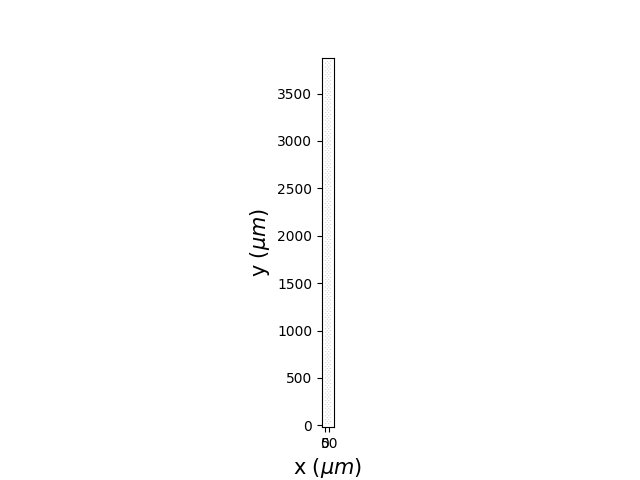

In [15]:
sw.plot_probe_map(recording_nwb)

The `widgets` module includes several convenient plotting functions that can be used to explore the data:

### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [17]:
print("Properties:\n", list(recording_nwb.get_property_keys()))

Properties:
 ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'imp', 'brain_area', 'filtering', 'shank_electrode_number', 'channel_name']


Let's add some new properties! 
The first 192 channels are in the CA1 area, the second 192 are in the CA3 area:

In [ ]:
brain_area_property_values = ['CA1']*192 + ['CA3']*192
print(brain_area_property_values)

['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1'

In [19]:
recording_nwb.set_property(key='brain_area', values=brain_area_property_values)

We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

In [20]:
recording_nwb.set_property(key='quality', values=["good"]*(recording_nwb.get_num_channels() - 3),
                           ids=recording_nwb.get_channel_ids()[:-3])

In [21]:
recording_nwb.get_property("quality")[-10:]

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', '', '', ''],
      dtype='<U4')

In [22]:
print("Properties after adding custom properties:\n", list(recording_nwb.get_property_keys()))

Properties after adding custom properties:
 ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'imp', 'brain_area', 'filtering', 'shank_electrode_number', 'channel_name', 'quality']


**NOTE:** Internally the properties is just a dictionary attached to the recording that is accessible as `_properties`

In [23]:
print(recording_nwb._properties.keys())

dict_keys(['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'imp', 'brain_area', 'filtering', 'shank_electrode_number', 'channel_name', 'quality'])


### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [24]:
recording_nwb.annotate(description="Dataset for COSYNE 2023 tutorial.")

In [25]:
print(recording_nwb.get_annotation_keys())

['is_filtered', 'probes_info', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `preprocessing` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

In [26]:
recording_to_process = recording_nwb

Below, we bandpass filter the recording and apply common median reference to the original recording:

In [27]:
recording_f = spre.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)

Let's now apply Common Median Reference (CMR):

In [28]:
recording_cmr = spre.common_reference(recording_f, reference='global', operator='median')

We can plot the traces after applying CMR:

In [29]:
w = sw.plot_timeseries({"raw": recording_to_process, "filt": recording_f, "common": recording_cmr},
                        clim=(-50, 50), time_range=[10, 10.1], order_channel_by_depth=True,
                        backend="ipywidgets")

## Take only 5 min. for demo

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [ ]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=300*fs)
recording_sub

FrameSliceRecording: 384 channels - 1 segments - 30.0kHz - 300.000s

In [31]:
sorting_nwb_sub = sorting_nwb.frame_slice(start_frame=0*fs, end_frame=300*fs)
sorting_nwb_sub

FrameSliceSorting: 77 units - 1 segments - 30.0kHz

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [32]:
job_kwargs = dict(n_jobs=10, chunk_duration="1s", progress_bar=True)

In [33]:
if (base_folder / "preprocessed").is_dir():
    recording_saved = si.load_extractor(base_folder / "preprocessed")
else:
    recording_saved = recording_sub.save(folder=base_folder / "preprocessed", **job_kwargs)

If we inspect the `preprocessed` folder, we find that a few files have been saved. Let's take a look at what they are:

In [34]:
recording_saved

BinaryFolderRecording: 384 channels - 1 segments - 30.0kHz - 300.000s

In [35]:
!ls {base_folder}/preprocessed

binary.json            properties             si_folder.json
probe.json             provenance.json        traces_cached_seg0.raw


The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. 

The `save` returns a new *cached* recording that has all the previously loaded information:

In [36]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching: {recording_saved.get_channel_groups()}')

Cached channels ids: ['AP0' 'AP1' 'AP2' 'AP3' 'AP4' 'AP5' 'AP6' 'AP7' 'AP8' 'AP9' 'AP10' 'AP11'
 'AP12' 'AP13' 'AP14' 'AP15' 'AP16' 'AP17' 'AP18' 'AP19' 'AP20' 'AP21'
 'AP22' 'AP23' 'AP24' 'AP25' 'AP26' 'AP27' 'AP28' 'AP29' 'AP30' 'AP31'
 'AP32' 'AP33' 'AP34' 'AP35' 'AP36' 'AP37' 'AP38' 'AP39' 'AP40' 'AP41'
 'AP42' 'AP43' 'AP44' 'AP45' 'AP46' 'AP47' 'AP48' 'AP49' 'AP50' 'AP51'
 'AP52' 'AP53' 'AP54' 'AP55' 'AP56' 'AP57' 'AP58' 'AP59' 'AP60' 'AP61'
 'AP62' 'AP63' 'AP64' 'AP65' 'AP66' 'AP67' 'AP68' 'AP69' 'AP70' 'AP71'
 'AP72' 'AP73' 'AP74' 'AP75' 'AP76' 'AP77' 'AP78' 'AP79' 'AP80' 'AP81'
 'AP82' 'AP83' 'AP84' 'AP85' 'AP86' 'AP87' 'AP88' 'AP89' 'AP90' 'AP91'
 'AP92' 'AP93' 'AP94' 'AP95' 'AP96' 'AP97' 'AP98' 'AP99' 'AP100' 'AP101'
 'AP102' 'AP103' 'AP104' 'AP105' 'AP106' 'AP107' 'AP108' 'AP109' 'AP110'
 'AP111' 'AP112' 'AP113' 'AP114' 'AP115' 'AP116' 'AP117' 'AP118' 'AP119'
 'AP120' 'AP121' 'AP122' 'AP123' 'AP124' 'AP125' 'AP126' 'AP127' 'AP128'
 'AP129' 'AP130' 'AP131' 'AP132' 'AP133' 'AP

After saving the SI object, we can easily load it back in a new session:

In [37]:
recording_loaded = si.load_extractor(base_folder / "preprocessed")

In [38]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')
print(f'Channel groups after loading: {recording_loaded.get_channel_groups()}')

Loaded channels ids: ['AP0' 'AP1' 'AP2' 'AP3' 'AP4' 'AP5' 'AP6' 'AP7' 'AP8' 'AP9' 'AP10' 'AP11'
 'AP12' 'AP13' 'AP14' 'AP15' 'AP16' 'AP17' 'AP18' 'AP19' 'AP20' 'AP21'
 'AP22' 'AP23' 'AP24' 'AP25' 'AP26' 'AP27' 'AP28' 'AP29' 'AP30' 'AP31'
 'AP32' 'AP33' 'AP34' 'AP35' 'AP36' 'AP37' 'AP38' 'AP39' 'AP40' 'AP41'
 'AP42' 'AP43' 'AP44' 'AP45' 'AP46' 'AP47' 'AP48' 'AP49' 'AP50' 'AP51'
 'AP52' 'AP53' 'AP54' 'AP55' 'AP56' 'AP57' 'AP58' 'AP59' 'AP60' 'AP61'
 'AP62' 'AP63' 'AP64' 'AP65' 'AP66' 'AP67' 'AP68' 'AP69' 'AP70' 'AP71'
 'AP72' 'AP73' 'AP74' 'AP75' 'AP76' 'AP77' 'AP78' 'AP79' 'AP80' 'AP81'
 'AP82' 'AP83' 'AP84' 'AP85' 'AP86' 'AP87' 'AP88' 'AP89' 'AP90' 'AP91'
 'AP92' 'AP93' 'AP94' 'AP95' 'AP96' 'AP97' 'AP98' 'AP99' 'AP100' 'AP101'
 'AP102' 'AP103' 'AP104' 'AP105' 'AP106' 'AP107' 'AP108' 'AP109' 'AP110'
 'AP111' 'AP112' 'AP113' 'AP114' 'AP115' 'AP116' 'AP117' 'AP118' 'AP119'
 'AP120' 'AP121' 'AP122' 'AP123' 'AP124' 'AP125' 'AP126' 'AP127' 'AP128'
 'AP129' 'AP130' 'AP131' 'AP132' 'AP133' 'AP

We can double check that the traces are exactly the same as the `recording_saved` that we saved:

**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use different spike sorters for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the available and installed sorters in `SpikeInterface`.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [40]:
ss.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'pykilosort',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [41]:
ss.installed_sorters()

['herdingspikes', 'spykingcircus2', 'tridesclous2']

The `spikeinterface.sortingcomponents` module includes functions that can be used to create custom spike sorting pipelines built-in in `SpikeInterface`. It is still experimental and under heavy development, but there are already two SI-based sorters available:

* `tridesclous2` (developed by Samuel Garcia)
* `spykingcircus2` (developed by Pierre Yger)

They can be run with the same `run_sorter` function, but they don't require any additional installation!

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [42]:
ss.get_default_sorter_params('ironclust')

{'detect_sign': -1,
 'adjacency_radius': 50,
 'adjacency_radius_out': 100,
 'detect_threshold': 3.5,
 'prm_template_name': '',
 'freq_min': 300,
 'freq_max': 8000,
 'merge_thresh': 0.985,
 'pc_per_chan': 9,
 'whiten': False,
 'filter_type': 'bandpass',
 'filter_detect_type': 'none',
 'common_ref_type': 'trimmean',
 'batch_sec_drift': 300,
 'step_sec_drift': 20,
 'knn': 30,
 'min_count': 30,
 'fGpu': True,
 'fft_thresh': 8,
 'fft_thresh_low': 0,
 'nSites_whiten': 16,
 'feature_type': 'gpca',
 'delta_cut': 1,
 'post_merge_mode': 1,
 'sort_mode': 1,
 'fParfor': False,
 'filter': True,
 'clip_pre': 0.25,
 'clip_post': 0.75,
 'merge_thresh_cc': 1,
 'nRepeat_merge': 3,
 'merge_overlap_thresh': 0.95,
 'n_jobs': 10,
 'chunk_duration': '1s',
 'progress_bar': True}

In [43]:
ss.run_sorter?

To modify a parameter, we can easily pass it to the `run` function as an extra argument!

## Run sorter in container

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker/singularity installed
2. have docker/singularity python SDK installed (`pip install docker/spython`)
3. have docker/singularity booted up and running in the background

In [46]:
# run spike sorting on entire recording
sorting_herdingspikes = ss.run_sorter(
    sorter_name='herdingspikes',
    recording=recording_saved,
    output_folder=base_folder / 'herdingspikes',
    verbose=True,
    docker_image=True,
)

Starting container
Installing spikeinterface==0.97.0 in spikeinterface/herdingspikes-base
Running herdingspikes sorter inside spikeinterface/herdingspikes-base
Stopping container


In [47]:
print(sorting_herdingspikes)

HerdingspikesSortingExtractor: 70 units - 1 segments - 30.0kHz
  file_path: /Users/codybaker/Downloads/spikeinterface_tutorial/herdingspikes/sorter_output/HS2_sorted.hdf5


In [48]:
print(f'Herdingspikes found {len(sorting_herdingspikes.get_unit_ids())} units!')

Herdingspikes found 70 units!


In [49]:
sorting_herdingspikes = sorting_herdingspikes.remove_empty_units()
print(f'Herdingspikes found {len(sorting_herdingspikes.get_unit_ids())} non-empty units!')

Herdingspikes found 70 non-empty units!


# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

Post-processing of spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

In the SI API, waveforms are extracted using the `WaveformExtractor` class in the `core` module.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [50]:
recording_saved = si.load_extractor(base_folder / "preprocessed")
sorting = sorting_herdingspikes
print(sorting)

UnitsSelectionSorting: 70 units - 1 segments - 30.0kHz


In [51]:
si.extract_waveforms?

In [52]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms", 
                          load_if_exists=False, overwrite=True, **job_kwargs)
print(we)

extract waveforms memmap:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 384 channels - 70 units - 1 segments
  before:90 after:120 n_per_units:500


Now all waveforms are computed and stored in the provided `waveforms` folder. We can now retrieve waveforms and templates easily:

In [53]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
template0 = we.get_template(unit_id=0)
print(f"Template shape: {template0.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

Waveforms shape: (500, 210, 384)
Template shape: (210, 384)
All templates shape: (70, 210, 384)


For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). Note that the number of spikes in this case is 500..we'll get back to it later!

The `WaveformExtractor` is also compatible with several `widgets` to visualize the spike sorting output:

In [56]:
for unit in sorting.get_unit_ids():
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = sorting.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 500 - num spikes: 10185
Unit 1 - num waveforms: 500 - num spikes: 2992
Unit 2 - num waveforms: 500 - num spikes: 2678
Unit 3 - num waveforms: 500 - num spikes: 3570
Unit 4 - num waveforms: 500 - num spikes: 2499
Unit 5 - num waveforms: 500 - num spikes: 2155
Unit 6 - num waveforms: 500 - num spikes: 1998
Unit 7 - num waveforms: 500 - num spikes: 2274
Unit 8 - num waveforms: 500 - num spikes: 1638
Unit 9 - num waveforms: 500 - num spikes: 1530
Unit 10 - num waveforms: 500 - num spikes: 1248
Unit 11 - num waveforms: 500 - num spikes: 1151
Unit 12 - num waveforms: 500 - num spikes: 1535
Unit 13 - num waveforms: 500 - num spikes: 1058
Unit 14 - num waveforms: 500 - num spikes: 1009
Unit 15 - num waveforms: 500 - num spikes: 1001
Unit 16 - num waveforms: 500 - num spikes: 1233
Unit 17 - num waveforms: 500 - num spikes: 1085
Unit 18 - num waveforms: 500 - num spikes: 1151
Unit 19 - num waveforms: 500 - num spikes: 1019
Unit 20 - num waveforms: 500 - num spikes: 872
Un

No units have more than 500 spikes! This is because by default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we can use the `max_spikes_per_unit` argument:

In [57]:
we_all = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_all", 
                              max_spikes_per_unit=None,
                              overwrite=True,
                              **job_kwargs)

extract waveforms memmap:   0%|          | 0/300 [00:00<?, ?it/s]

In [58]:
for unit in sorting.get_unit_ids():
    waveforms = we_all.get_waveforms(unit_id=unit)
    spiketrain = sorting.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 10185 - num spikes: 10185
Unit 1 - num waveforms: 2992 - num spikes: 2992
Unit 2 - num waveforms: 2678 - num spikes: 2678
Unit 3 - num waveforms: 3570 - num spikes: 3570
Unit 4 - num waveforms: 2499 - num spikes: 2499
Unit 5 - num waveforms: 2155 - num spikes: 2155
Unit 6 - num waveforms: 1998 - num spikes: 1998
Unit 7 - num waveforms: 2274 - num spikes: 2274
Unit 8 - num waveforms: 1638 - num spikes: 1638
Unit 9 - num waveforms: 1530 - num spikes: 1530
Unit 10 - num waveforms: 1248 - num spikes: 1248
Unit 11 - num waveforms: 1151 - num spikes: 1151
Unit 12 - num waveforms: 1535 - num spikes: 1535
Unit 13 - num waveforms: 1058 - num spikes: 1058
Unit 14 - num waveforms: 1009 - num spikes: 1009
Unit 15 - num waveforms: 1001 - num spikes: 1001
Unit 16 - num waveforms: 1233 - num spikes: 1233
Unit 17 - num waveforms: 1085 - num spikes: 1085
Unit 18 - num waveforms: 1151 - num spikes: 1151
Unit 19 - num waveforms: 1019 - num spikes: 1019
Unit 20 - num waveforms: 872

Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `postprocessing` module.

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analysis (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `postprocessing` module.

## Sparsity

Especially when working with silicon high-density probes, or when our probe has multiple groups (e.g. multi-shank, tetrodes), we don't care about waveform/templates on all channels. In order to find a subset of channels for each unit, we can use the `get_template_channel_sparsity()`

In [59]:
spost.get_template_channel_sparsity?

In [60]:
# example: radius
sparsity_radius = spost.get_template_channel_sparsity(we, method="radius", radius_um=50)
print(sparsity_radius[sorting.unit_ids[0]])

['AP110' 'AP112' 'AP114' 'AP115' 'AP116' 'AP118']


In [61]:
# example: best
sparsity_best = spost.get_template_channel_sparsity(we, method="best_channels", num_channels=4)
print(sparsity_best[sorting.unit_ids[0]])

['AP110' 'AP112' 'AP114' 'AP116']


### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [64]:
spost.compute_principal_components?

In [67]:
pc = spost.compute_principal_components(we, n_components=3,
                                        load_if_exists=False,
                                        n_jobs=job_kwargs["n_jobs"], 
                                        progress_bar=job_kwargs["progress_bar"])

Fitting PCA:   0%|          | 0/70 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/70 [00:00<?, ?it/s]

In [68]:
pc0 = pc.get_projections(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_projections()
print(f"All PC scores shape: {all_pcs.shape}")

PC scores shape: (500, 3, 384)
All PC scores shape: (29108, 3, 384)


For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 

## WaveformExtensions

When we compute PCA (or use other postprocessing functions), the computed information is added to the waveform folder. The functions act as `WaveformExtensions`:

In [69]:
we.get_available_extension_names()

['principal_components']

Each `WaveformExtension` is an object that allows us to retrieve the data:

In [70]:
pc = we.load_extension("principal_components")
print(pc)

WaveformPrincipalComponent: 384 channels - 1 segments
  mode: by_channel_local n_components: 3


In [71]:
all_labels, all_pcs = pc.get_data()
print(all_pcs.shape)

(29108, 3, 384)


### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [72]:
amplitudes = spost.compute_spike_amplitudes(we, outputs="by_unit", load_if_exists=True, 
                                            **job_kwargs)

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

By default, all amplitudes are concatenated in one array with all amplitudes form all spikes. With the `output="by_unit"` argument, instead, a dictionary is returned:

In [75]:
amplitudes[0][0]

array([-119.53125,  -96.09375, -100.78125, ...,  -96.09375, -110.15625,
       -105.46875], dtype=float32)

In [74]:
sw.plot_amplitudes(we, backend="ipywidgets")

AppLayout(children=(Checkbox(value=False, description='plot histograms', layout=Layout(grid_area='footer')), V…

### Compute unit and spike locations

When using silicon probes, we can estimate the unit (or spike) location with triangulation. This can be done either with a simple center of mass or by assuming a monopolar model:

$$V_{ext}(\boldsymbol{r_{ext}}) = \frac{I_n}{4 \pi \sigma |\boldsymbol{r_{ext}} - \boldsymbol{r_{n}}|}$$

where $\boldsymbol{r_{n}}$ is the position of the neuron, and $\boldsymbol{r_{n}}$ of the electrode(s).

In [76]:
unit_locations = spost.compute_unit_locations(we, method="monopolar_triangulation", load_if_exists=True)
spike_locations = spost.compute_spike_locations(we, method="center_of_mass", load_if_exists=True,
                                                **job_kwargs)

localize peaks:   0%|          | 0/300 [00:00<?, ?it/s]

In [77]:
sw.plot_unit_locations(we, backend="ipywidgets")

AppLayout(children=(VBox(children=(Label(value='units:'), SelectMultiple(index=(0,), layout=Layout(height='10c…

In [78]:
sw.plot_spike_locations(we, max_spikes_per_unit=300, backend="ipywidgets")

AppLayout(children=(VBox(children=(Label(value='units:'), SelectMultiple(index=(0,), layout=Layout(height='10c…

### Compute correlograms

In [79]:
ccgs, bins = spost.compute_correlograms(we)

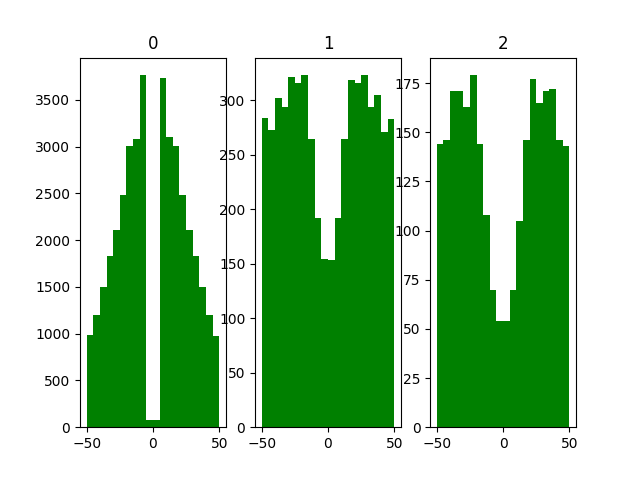

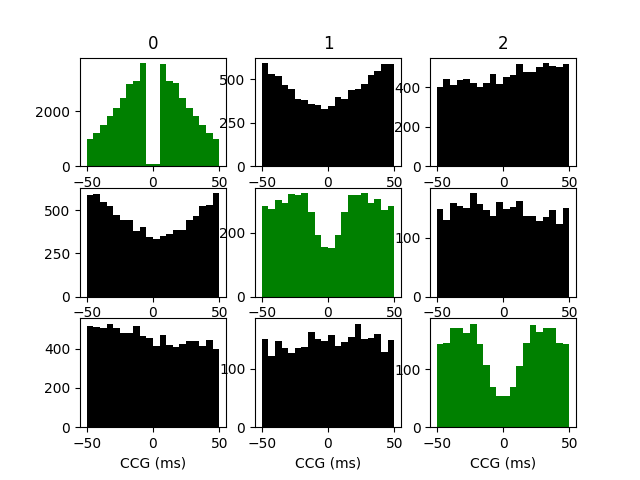

In [80]:
sw.plot_autocorrelograms(we, unit_ids=sorting.unit_ids[:3])
sw.plot_crosscorrelograms(we, unit_ids=sorting.unit_ids[:3])

### Compute template similarity

In [81]:
similarity = spost.compute_template_similarity(we)

In [83]:
similarity

array([[ 1.0000116 ,  0.00702434,  0.00953461, ..., -0.0077904 ,
         0.006016  ,  0.02337275],
       [ 0.00702434,  1.0000143 ,  0.01633305, ...,  0.00469869,
         0.01106327,  0.06301387],
       [ 0.00953461,  0.01633305,  1.0000069 , ..., -0.01367528,
        -0.00216431,  0.36891627],
       ...,
       [-0.0077904 ,  0.00469869, -0.01367528, ...,  1.0000087 ,
        -0.01176798, -0.01717472],
       [ 0.006016  ,  0.01106327, -0.00216431, ..., -0.01176798,
         0.9999971 ,  0.01130322],
       [ 0.02337275,  0.06301387,  0.36891627, ..., -0.01717472,
         0.01130322,  1.0000068 ]], dtype=float32)

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` allows one to compute several of these metrics:

In [82]:
print(spost.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope']


In [84]:
template_metrics = spost.calculate_template_metrics(we)
display(template_metrics)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope
0,0.000927,-0.277426,0.000313,287730.43089,-46956.445299
1,0.00063,-0.3309,0.000187,892814.236653,-123017.987467
2,0.000673,-0.322092,0.0002,465039.886645,-79102.745394
3,0.000213,-0.49179,0.000187,1264994.58192,-93619.291777
4,0.0007,-0.255925,0.000163,733732.342814,-73739.681006
...,...,...,...,...,...
65,0.00069,-0.222074,0.00015,593894.688824,-62531.836129
66,0.00057,-0.365289,0.000193,546970.757291,-83114.639046
67,0.000467,-0.269792,0.00017,953869.656429,-51734.634502
68,0.000633,-0.321801,0.000217,342307.10952,-47914.641454


In [85]:
sw.plot_template_metrics(we, include_metrics=["peak_to_valley", "half_width"], 
                         backend="ipywidgets")

AppLayout(children=(VBox(children=(Label(value='units:'), SelectMultiple(layout=Layout(height='10cm', width='3…

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymetrics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [87]:
print(sqm.get_quality_metric_list())
print(sqm.get_quality_pca_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'drift']
['isolation_distance', 'l_ratio', 'd_prime', 'nearest_neighbor', 'nn_isolation', 'nn_noise_overlap']


In [89]:
qm = sqm.compute_quality_metrics(we, verbose=True, 
                                 n_jobs=job_kwargs["n_jobs"])

Computing num_spikes
Computing firing_rate
Computing presence_ratio
Computing snr
Computing isi_violation
Computing rp_violation
Error: numba is not installed.
compute_refrac_period_violations cannot run without numba.
Computing sliding_rp_violation
Computing amplitude_cutoff
Computing amplitude_median
Computing drift


Computing PCA metrics:   0%|          | 0/70 [00:00<?, ?it/s]

In [90]:
display(qm)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,sliding_rp_violation,amplitude_cutoff,amplitude_median,drift_ptp,drift_std,drift_mad,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate
0,10185,33.950000,1.0,10.541825,0.007712,8,0.005,0.000337,107.81250,0.336426,0.119377,0.070237,1.582826e+16,NaN,5.984083,0.016082,0.002162
1,2992,9.973333,1.0,14.861369,0.223412,20,0.040,0.000250,208.59375,0.589545,0.215562,0.197512,1.542560e+17,NaN,5.421937,0.138889,0.010505
2,2678,8.926667,1.0,10.694035,0.055775,4,0.050,0.002782,147.65625,0.547141,0.198845,0.185374,4.369987e+16,NaN,4.792875,0.073099,0.019000
3,3570,11.900000,1.0,14.742996,1.843875,235,0.030,0.000129,159.37500,0.502888,0.219193,0.206375,1.126066e+16,NaN,4.427819,0.019006,0.000890
4,2499,8.330000,1.0,12.479073,0.032026,2,0.060,0.000466,178.12500,0.681419,0.316540,0.273123,1.568340e+16,NaN,5.221314,0.128655,0.017219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,139,0.463333,1.0,9.949451,0.000000,0,NaN,NaN,138.28125,NaN,NaN,NaN,1.019532e+16,NaN,4.924601,0.021277,0.003642
66,139,0.463333,1.0,12.569448,0.000000,0,NaN,NaN,110.15625,NaN,NaN,NaN,7.862459e+15,NaN,3.396680,0.031915,0.000829
67,305,1.016667,1.0,12.573521,0.000000,0,NaN,NaN,128.90625,NaN,NaN,NaN,1.770598e+16,NaN,4.217884,0.055288,0.003057
68,228,0.760000,1.0,9.137167,0.000000,0,NaN,NaN,96.09375,NaN,NaN,NaN,5.555866e+15,NaN,4.095774,0.080128,0.010381


In [91]:
sw.plot_quality_metrics(we, include_metrics=["amplitude_cutoff", "presence_ratio", "isi_violations_ratio", "snr"], 
                        backend="ipywidgets")

AppLayout(children=(VBox(children=(Label(value='units:'), SelectMultiple(layout=Layout(height='10cm', width='3…

For more information about these waveform features, we refer to the [SpikeInterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) and to this excellent [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qm` dataframe based on some thresholds.

Here, we'll only keep units with an ISI violation threshold < 0.2 and amplitude cutoff < 0.9:

In [92]:
isi_viol_thresh = 0.2
amp_cutoff_thresh = 0.1

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [97]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

amplitude_cutoff < 0.1 & isi_violations_ratio < 0.2


and then we can use the query to select units:

In [98]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values

In [99]:
sorting_auto_KS25 = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KS25.get_unit_ids())}")

Number of units before curation: 70
Number of units after curation: 32


We can also save all the waveforms and post-processed data for curated units in a separate folder:

In [100]:
we_curated = we.select_units(keep_unit_ids, new_folder="waveforms_curated")

In [101]:
print(we_curated)

WaveformExtractor: 384 channels - 32 units - 1 segments
  before:90 after:120 n_per_units:500


In [102]:
we_curated.get_available_extension_names()

['template_metrics',
 'similarity',
 'principal_components',
 'spike_amplitudes',
 'correlograms',
 'spike_locations',
 'unit_locations',
 'quality_metrics']

# 9. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

### Compare two sorters

In [ ]:
comp_KS2_KS25 = sc.compare_two_sorters(sorting_KS2, sorting_KS25, 'KS2', 'KS25')

In [ ]:
sw.plot_agreement_matrix(comp_KS2_KS25)

In [ ]:
comp_KS2_KS25auto = sc.compare_two_sorters(sorting_KS2, sorting_auto_KS25, 'KS2', 'KS25_auto')

In [ ]:
sw.plot_agreement_matrix(comp_KS2_KS25auto)

### Compare multiple sorters

In [ ]:
mcmp = sc.compare_multiple_sorters([sorting_KS2, sorting_KS25], ['KS2', 'KS25'], 
                                   spiketrain_mode='union', verbose=True)

In [ ]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [ ]:
sw.plot_multicomp_graph(mcmp, draw_labels=False)

In [ ]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)
print(agreement_sorting)

In [ ]:
sw.plot_rasters(agreement_sorting)

In [ ]:
# compare consensus and auto
comp_agr_auto = sc.compare_two_sorters(agreement_sorting, sorting_auto_KS25, 'AGR', 'AUTO')

In [ ]:
sw.plot_agreement_matrix(comp_agr_auto)

# 10. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [ ]:
sexp.export_to_phy?

In [ ]:
sexp.export_to_phy(we, output_folder=base_folder / 'phy_KS25', 
                   compute_amplitudes=False, compute_pc_features=False, copy_binary=True,
                   **job_kwargs)

There is a problem with the latest version of Phy so we need to set an environment variable to make it work properly:

- Python:
```
import os
os.environ["QTWEBENGINE_CHROMIUM_FLAGS"] = "--single-process"
```

- OR terminal:

  - Linux/MacOS:
`export QTWEBENGINE_CHROMIUM_FLAGS="--single-process"`

  - Windows:
`set QTWEBENGINE_CHROMIUM_FLAGS="--single-process"`

Then we can run the Phy GUI:

In [ ]:
import os
os.environ["QTWEBENGINE_CHROMIUM_FLAGS"] = "--single-process"

In [ ]:
# %%capture --no-display
# !phy template-gui phy_KS25/params.py

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [ ]:
sorting_phy_curated = se.PhySortingExtractor(base_folder / 'phy_KS25/', exclude_cluster_groups=['noise'])

In [ ]:
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_phy_curated.get_unit_ids())}")

### That's all for today! Thanks!